In [14]:
#Importing my need Dependencies
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import os
os.getcwd()

'/content/drive/MyDrive/PYTHON PROJECT'

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
os.chdir('/content/drive/MyDrive/PYTHON PROJECT')
#os.listdir()

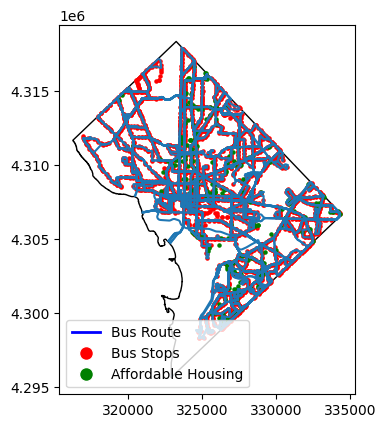

Average distance from clipped_filtered_house to clipped bus route: 5191.476013154117
Average distance from clipped_filtered_house to nearest shapefile stops: 6739.9245147125375


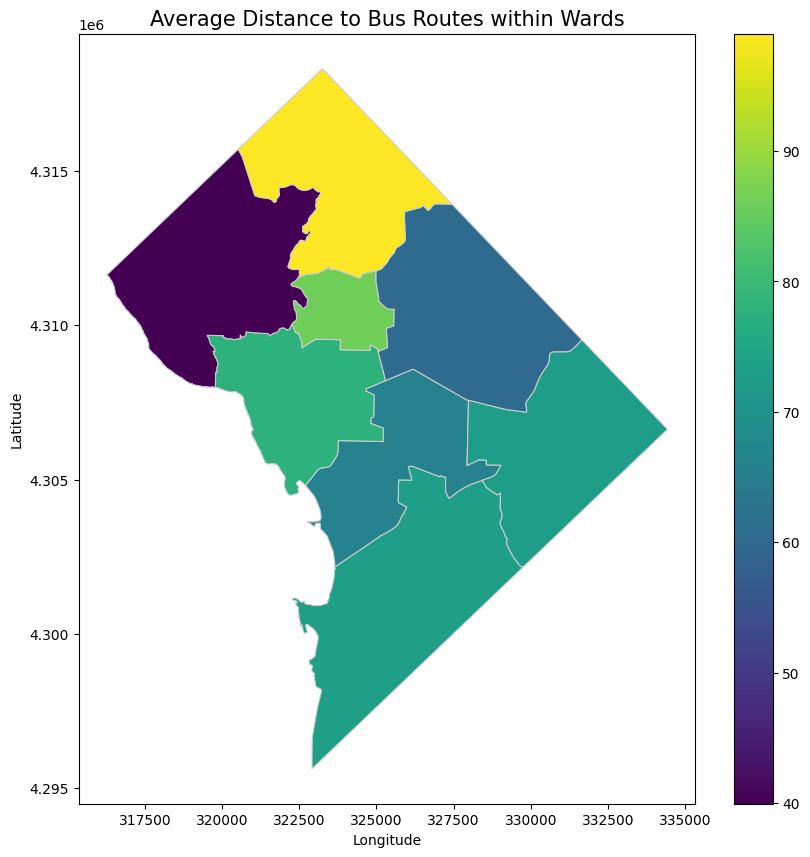

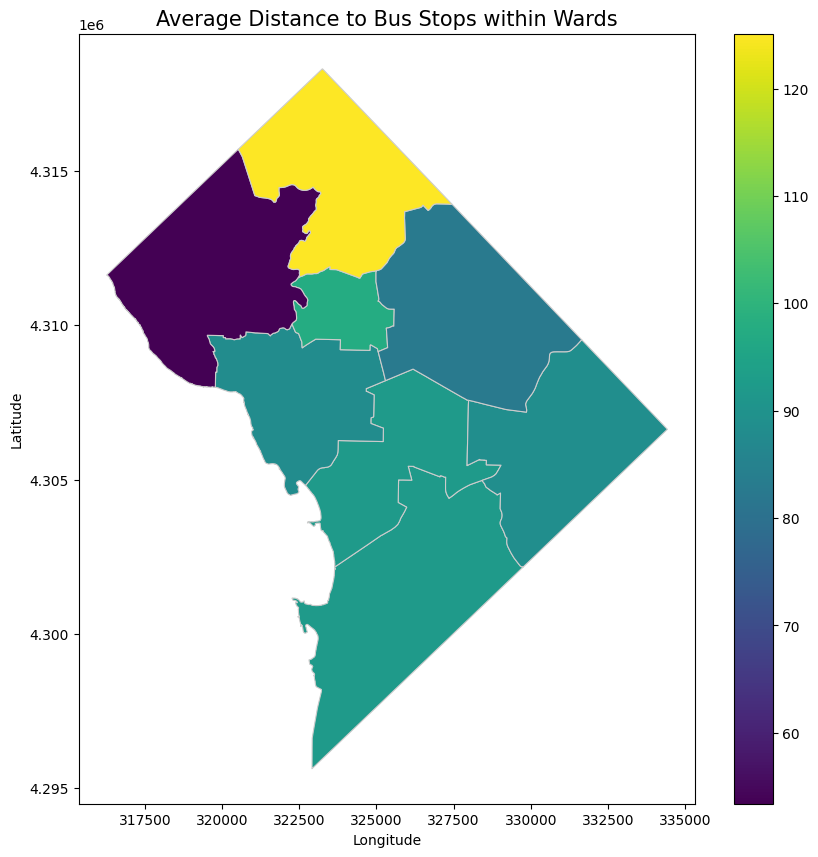

Average distance to bus routes in each ward: [72.94144747561417, 66.15418545976296, 72.66840048890478, 77.79447912763618, 85.97887361176612, 60.449589770017276, 39.96825594098374, 98.98257084683914]
Average distance to bus stops in each ward: [92.14449061182121, 92.2724729175487, 88.47306775688496, 88.12769450719841, 97.37773250899343, 82.67013729959224, 53.39317689432512, 125.10536707874537]


In [17]:

# Define coordinate systems
UTM18 = 26918
WGS84 = 4326

# Read the shapefiles
dcboundary = gpd.read_file('/content/drive/MyDrive/PYTHON PROJECT/Washington_DC_Boundary/Washington_DC_Boundary.shp')
busroute = gpd.read_file('/content/drive/MyDrive/PYTHON PROJECT/Metro_Bus_Lines/Metro_Bus_Lines.shp')
shapefilestops = gpd.read_file('/content/drive/MyDrive/PYTHON PROJECT/Metro_Bus_Stops/Metro_Bus_Stops.shp')
house = gpd.read_file('/content/drive/MyDrive/PYTHON PROJECT/Affordable_Housing 3/Affordable_Housing.shp')
wards = gpd.read_file('/content/drive/MyDrive/PYTHON PROJECT/Wards_from_2022/Wards_from_2022.shp')

# Project all GeoDataFrames to UTM zone 18N (EPSG code 26918)
dcboundary = dcboundary.to_crs(UTM18)
busroute = busroute.to_crs(UTM18)
shapefilestops = shapefilestops.to_crs(UTM18)
house = house.to_crs(UTM18)
wards = wards.to_crs(UTM18)

def analyze_public_transport_accessibility(column_name):
    # Filter houses based on the given column name
    filtered_house = house[house[column_name] > 1]
    filtered_house = filtered_house.to_crs(UTM18)

    # Define the legend labels and colors
    legend_labels = ['Bus Route', 'Bus Stops', 'Affordable Housing']
    legend_colors = ['blue', 'red', 'green']

    # Create a new plot
    fig, ax = plt.subplots()

    # Plot the DC Boundary shapefile with outline
    dcboundary.plot(ax=ax, edgecolor='black', facecolor='none')

    # Clip bus routes layer to the boundary of DC
    clipped_shapefile2 = gpd.clip(busroute, dcboundary)

    # Plot the clipped bus route
    clipped_shapefile2.plot(ax=ax)

    # Clip bus stop feature to the boundary of DC
    clipped_shapefilestops = gpd.clip(shapefilestops, dcboundary)

    # Plot the clipped bus stops
    clipped_shapefilestops.plot(ax=ax, color='red', markersize=5)

    # Clip filtered houses to the boundary of DC
    clipped_filtered_house = gpd.clip(filtered_house, dcboundary)
    clipped_filtered_house.plot(ax=ax, color='green', markersize=5)

    # Add legend
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Bus Route'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Bus Stops'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Affordable Housing')
    ]
    ax.legend(handles=legend_elements)

    # Add north arrow
    ax.annotate('N', xy=(0.5, 0.95), xytext=(0.5, 1.0), arrowprops=dict(facecolor='black', shrink=0.05))

    # Show the plot
    plt.show()

    # Calculate the distance from each point in clipped_filtered_house to the nearest point on the bus route
    distances = clipped_filtered_house.geometry.apply(lambda point: clipped_shapefile2.distance(point))
    average_distance = np.mean(distances)
    print(f"Average distance from clipped_filtered_house to clipped bus route: {average_distance}")

    # Calculate the distance from each point in clipped_filtered_house to the nearest point on the shapefilestops
    distances_to_stops = clipped_filtered_house.geometry.apply(lambda point: clipped_shapefilestops.distance(point))
    average_distance_to_stops = np.mean(distances_to_stops)
    print(f"Average distance from clipped_filtered_house to nearest shapefile stops: {average_distance_to_stops}")

def calculate_distances_within_wards(column_name):
    # Filter houses based on the specified column name
    filtered_house = house[house[column_name] > 1]

    # Initialize lists to store average distances for each ward
    route_distances = []
    stop_distances = []

    # Iterate over each ward
    for ward_id, ward_geom in wards[['WARD', 'geometry']].itertuples(index=False):
        # Filter houses within the current ward
        houses_within_ward = filtered_house[filtered_house.within(ward_geom)]

        # Calculate the distance from each house to the nearest point on the bus route within the ward
        house_to_route_distances = []
        for house_point in houses_within_ward.geometry:
            house_to_route_distances.append(busroute.distance(house_point).min())

        # Calculate the distance from each house to the nearest bus stop within the ward
        house_to_stop_distances = []
        for house_point in houses_within_ward.geometry:
            house_to_stop_distances.append(shapefilestops.distance(house_point).min())

        # Calculate the average distances within the ward
        if house_to_route_distances:
            route_distances.append(sum(house_to_route_distances) / len(house_to_route_distances))
        else:
            route_distances.append(None)  # If no houses within the ward, set distance to None

        if house_to_stop_distances:
            stop_distances.append(sum(house_to_stop_distances) / len(house_to_stop_distances))
        else:
            stop_distances.append(None)  # If no houses within the ward, set distance to None

    # Add average distances to the wards GeoDataFrame
    wards['avg_distance_to_route'] = route_distances
    wards['avg_distance_to_stop'] = stop_distances

    return wards, route_distances, stop_distances

def plot_choropleth_map(data, column_name, title):
    # Plot choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    data.plot(column=column_name, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})

    # Add labels for axes
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()

# Call the functions with the desired column name
analyze_public_transport_accessibility('AFFORDABLE')
wards_with_distances, route_distances, stop_distances = calculate_distances_within_wards('AFFORDABLE')

# Plot choropleth map for average distance to bus routes within wards
plot_choropleth_map(wards_with_distances, 'avg_distance_to_route', 'Average Distance to Bus Routes within Wards')

# Plot choropleth map for average distance to bus stops within wards
plot_choropleth_map(wards_with_distances, 'avg_distance_to_stop', 'Average Distance to Bus Stops within Wards')

# Print average distances
print("Average distance to bus routes in each ward:", route_distances)
print("Average distance to bus stops in each ward:", stop_distances)